In [2]:
import numpy as np  
import pandas as pd 
from sklearn.datasets import make_classification  
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text  
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve 
import matplotlib.pyplot as plt  

# GENERAR DATASET SINTÉTICO

X2, y2 = make_classification(
    n_samples=1000,       # 1000 solicitudes de préstamo
    n_features=8,         # 8 características del solicitante (ingresos, score crediticio, etc.)
    n_informative=4,      # 4 características realmente predictivas
    n_redundant=2,        # 2 características correlacionadas con las informativas
    n_clusters_per_class=2, # 2 subgrupos dentro de cada clase (aprobado/rechazado)
    class_sep=0.8,        # Separación entre clases (0.8 = moderadamente separables)
    random_state=1        # Semilla para reproducibilidad
)

# Crear DataFrame con nombres de características más descriptivos
cols2 = ['ingreso_mensual', 'score_crediticio', 'deuda_actual', 'antiguedad_laboral',
         'monto_solicitado', 'edad', 'nro_dependientes', 'valor_garantia']
df2 = pd.DataFrame(X2, columns=cols2)
df2['target'] = y2 

print("Dataset sintético generado - 1000 solicitudes de préstamo")
print(f"Características: {cols2}")
print(f"Dimensión del dataset: {df2.shape}")
print(f"Distribución de clases: {df2['target'].value_counts()}")


Dataset sintético generado - 1000 solicitudes de préstamo
Características: ['ingreso_mensual', 'score_crediticio', 'deuda_actual', 'antiguedad_laboral', 'monto_solicitado', 'edad', 'nro_dependientes', 'valor_garantia']
Dimensión del dataset: (1000, 9)
Distribución de clases: target
0    500
1    500
Name: count, dtype: int64


In [3]:
# DIVIDIR DATOS EN ENTRENAMIENTO Y PRUEBA

X2_train, X2_test, y2_train, y2_test = train_test_split(
    df2[cols2],          
    df2['target'],     
    test_size=0.25,    
    random_state=1,   
    stratify=df2['target'] 
)

print(f"\nDatos divididos:")
print(f"  - Entrenamiento: {X2_train.shape[0]} muestras")
print(f"  - Prueba: {X2_test.shape[0]} muestras")


Datos divididos:
  - Entrenamiento: 750 muestras
  - Prueba: 250 muestras


In [4]:
# ENTRENAR UN ÁRBOL BÁSICO (SIN PODA)
tree = DecisionTreeClassifier(
    random_state=1  
)
tree.fit(X2_train, y2_train) 

print(f"\nÁrbol básico entrenado (sin poda)")
print(f"  - Profundidad del árbol: {tree.get_depth()}")
print(f"  - Número de hojas: {tree.get_n_leaves()}")




Árbol básico entrenado (sin poda)
  - Profundidad del árbol: 11
  - Número de hojas: 73


In [5]:
# EVALUACIÓN BÁSICA DEL ÁRBOL SIN PODA
y2_pred = tree.predict(X2_test)              # Predicciones de clase (0/1)
y2_proba = tree.predict_proba(X2_test)[:, 1] # Probabilidades de clase 1 (aprobado)

print("Reporte de Clasificación - Árbol sin poda:")
print(classification_report(y2_test, y2_pred, 
                          target_names=['Rechazado', 'Aprobado']))

auc_basico = roc_auc_score(y2_test, y2_proba)
print(f"AUC-ROC: {auc_basico:.4f}")



Reporte de Clasificación - Árbol sin poda:
              precision    recall  f1-score   support

   Rechazado       0.80      0.86      0.83       125
    Aprobado       0.85      0.79      0.82       125

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.82       250
weighted avg       0.83      0.82      0.82       250

AUC-ROC: 0.8240


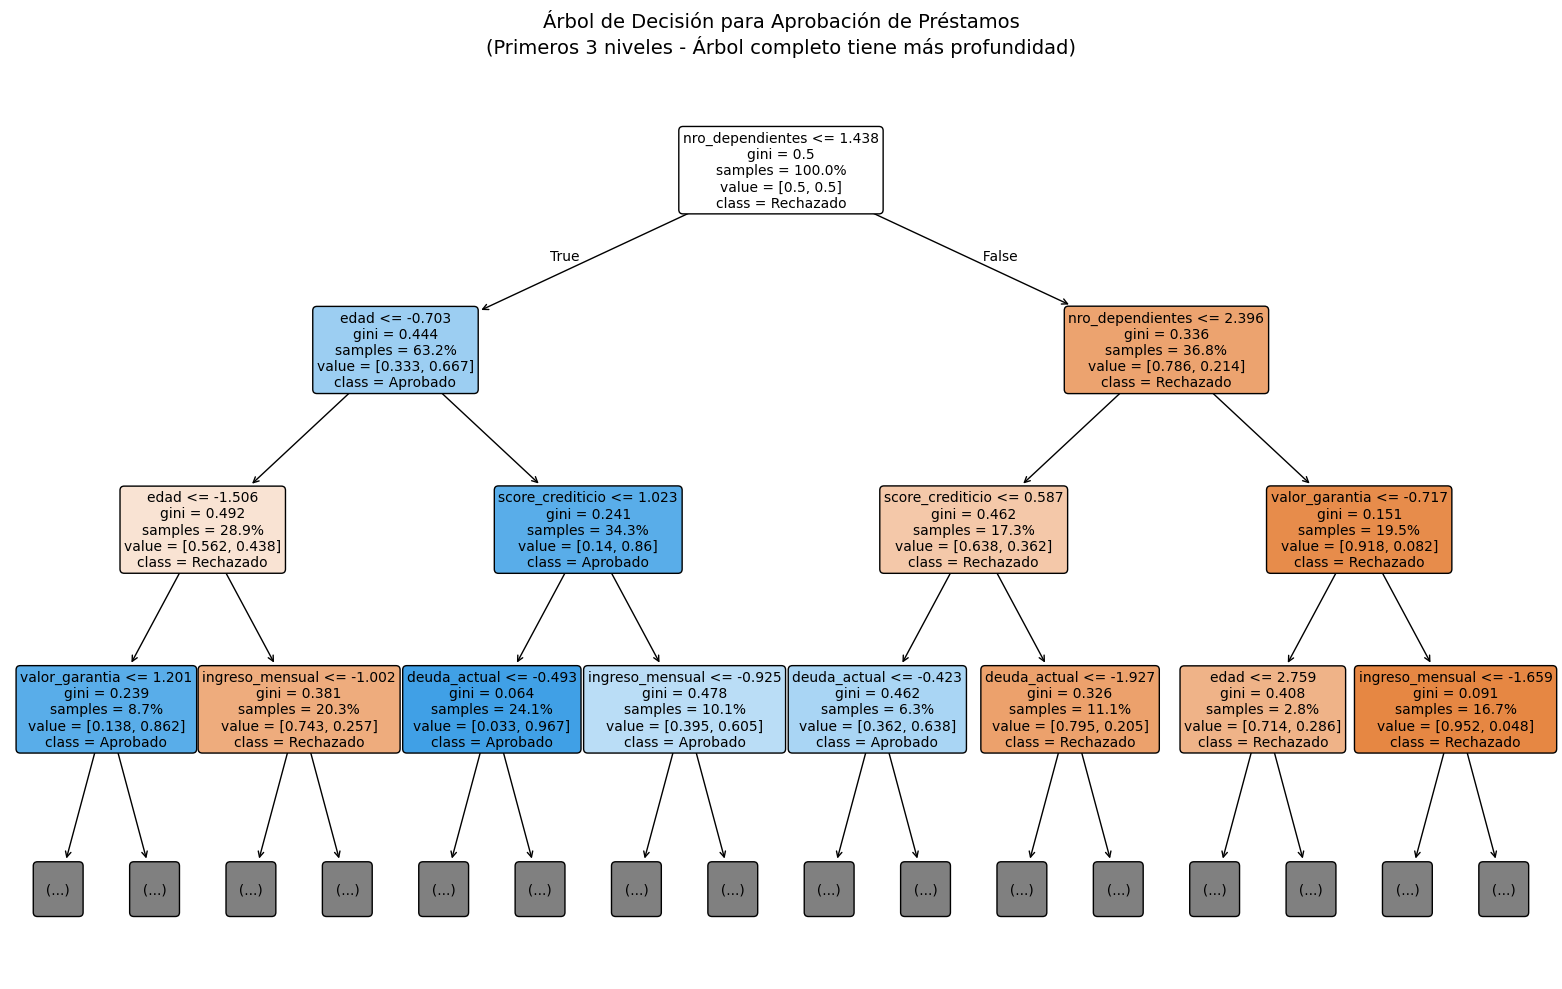

In [6]:
# VISUALIZACIÓN DEL ÁRBOL

plt.figure(figsize=(16, 10))
plot_tree(
    tree,                   # Árbol entrenado
    feature_names=cols2,    # Nombres de las características
    class_names=['Rechazado', 'Aprobado'],  # Nombres de las clases
    filled=True,            # Colorear nodos según la clase mayoritaria
    max_depth=3,            # Mostrar solo primeros 3 niveles (para legibilidad)
    fontsize=10,            # Tamaño de fuente
    proportion=True,        # Mostrar proporciones en lugar de conteos
    rounded=True            # Bordes redondeados
)
plt.title("Árbol de Decisión para Aprobación de Préstamos\n(Primeros 3 niveles - Árbol completo tiene más profundidad)", 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [7]:
# CONTROL DE SOBREAJUSTE

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, None],        #  profundidad (poda vertical)
    'min_samples_leaf': [1, 2, 5, 10, 20]      #  Controla tamaño de hojas (poda horizontal)
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=1),  # Estimador base: árbol de decisión con semilla fija
    param_grid,                             # Grilla de parámetros: 6 valores de depth × 5 de leaf = 30 combinaciones
    scoring='roc_auc',                      # Métrica para evaluar: Area Under ROC Curve (mejor para problemas binarios)
    cv=5,                                   # 5-fold cross validation: divide datos en 5 partes, usa 4 para entrenar y 1 para validar
    n_jobs=-1,                              # Paralelización: usa todos los cores del CPU para acelerar búsqueda
    verbose=1                               # Nivel de verbosidad: 1 = mostrar progreso de la búsqueda
)

grid.fit(X2_train, y2_train)
print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)
print(f"Mejor AUC en Validación Cruzada: {grid.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 10}
Mejor AUC en Validación Cruzada: 0.9033


In [8]:
# EVALUAR EL MEJOR MODELO EN CONJUNTO DE PRUEBA
best_tree = grid.best_estimator_  # Mejor modelo encontrado
y2_pred_best = best_tree.predict(X2_test)              # Predicciones con mejor modelo
y2_proba_best = best_tree.predict_proba(X2_test)[:, 1] # Probabilidades con mejor modelo


print("Reporte de Clasificación - Árbol optimizado:")
print(classification_report(y2_test, y2_pred_best, 
                          target_names=['Rechazado', 'Aprobado']))

auc_optimizado = roc_auc_score(y2_test, y2_proba_best)
print(f"AUC-ROC: {auc_optimizado:.4f}")

# Comparación entre árbol básico y optimizado
print(f"\nCOMPARACIÓN DE PERFORMANCE:")
print(f"Árbol sin poda - AUC: {auc_basico:.4f}")
print(f"Árbol con poda  - AUC: {auc_optimizado:.4f}")
print(f"Mejora: {auc_optimizado - auc_basico:.4f}")

Reporte de Clasificación - Árbol optimizado:
              precision    recall  f1-score   support

   Rechazado       0.78      0.86      0.81       125
    Aprobado       0.84      0.75      0.79       125

    accuracy                           0.80       250
   macro avg       0.81      0.80      0.80       250
weighted avg       0.81      0.80      0.80       250

AUC-ROC: 0.8773

COMPARACIÓN DE PERFORMANCE:
Árbol sin poda - AUC: 0.8240
Árbol con poda  - AUC: 0.8773
Mejora: 0.0533


In [9]:
# EXTRACCIÓN DE REGLAS DEL ÁRBOL

rules = export_text(
    best_tree,              # Árbol optimizado
    feature_names=cols2,    # Nombres reales de características  
    max_depth=4,            # Mostrar solo primeros 4 niveles
    decimals=2              # 2 decimales en valores de corte
)
print(rules) 

|--- nro_dependientes <= 1.44
|   |--- edad <= -0.70
|   |   |--- edad <= -1.51
|   |   |   |--- valor_garantia <= 1.20
|   |   |   |   |--- class: 0
|   |   |   |--- valor_garantia >  1.20
|   |   |   |   |--- class: 1
|   |   |--- edad >  -1.51
|   |   |   |--- ingreso_mensual <= -1.00
|   |   |   |   |--- class: 1
|   |   |   |--- ingreso_mensual >  -1.00
|   |   |   |   |--- edad <= -1.25
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- edad >  -1.25
|   |   |   |   |   |--- truncated branch of depth 6
|   |--- edad >  -0.70
|   |   |--- score_crediticio <= 1.02
|   |   |   |--- deuda_actual <= -0.49
|   |   |   |   |--- class: 1
|   |   |   |--- deuda_actual >  -0.49
|   |   |   |   |--- ingreso_mensual <= -1.40
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- ingreso_mensual >  -1.40
|   |   |   |   |   |--- class: 1
|   |   |--- score_crediticio >  1.02
|   |   |   |--- ingreso_mensual <= -0.93
|   |   |   |   |--- deuda_actual <= -0.05
|   |   |  